In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from math import sqrt
import scipy as sp
from scipy import stats
import scipy.signal
from scipy.signal import fftconvolve, convolve
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
import random as ran

from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import *

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn import datasets
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from textacy.preprocess import preprocess_text

from gensim import corpora, models, matutils
from collections import defaultdict, Counter

import statsmodels.api as sm
import statsmodels.formula.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf

import patsy
from itertools import combinations

from imblearn.over_sampling import SMOTE

import graphviz
import json
import requests
import urllib
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from time import sleep
import re
import twitter

%matplotlib inline
#plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Build and document a working model, prototype, recommendation, or solution

Note: The new Statcast metrics are available beginning from the 2015 baseball season to the current season. I downloaded the 2015-2017 baseball season data for all teams which will be used in the data modeling.

## [pybaseball](https://github.com/jldbc/pybaseball) 
Pull current and historical baseball statistics using Python (Statcast, Baseball Reference, FanGraphs)

`pybaseball` is a Python package for baseball data analysis. This package scrapes Baseball Reference, Baseball Savant, and FanGraphs so you don't have to. The package retrieves statcast data, pitching stats, batting stats, division standings/team records, awards data, and more. Data is available at the individual pitch level, as well as aggregated at the season level and over custom time periods. See the [docs](https://github.com/jldbc/pybaseball/tree/master/docs) for a comprehensive list of data acquisition functions.

**Statcast**

The statcast function retrieves pitch-level statcast data for a given date or range or dates.

statcast(start_dt=[yesterday's date], end_dt=None, team=None)

In [2]:
# Pull advanced metrics from Major League Baseball's Statcast system
#from pybaseball import statcast

# Look up a player's MLBAM, Retrosheet, FanGraphs, and Baseball Reference ID by name
#from pybaseball import playerid_lookup

### Reading a File

In [3]:
# Create data path variable for loading data
data_path = '/Users/yangweichle/Documents/GeneralAssembly/Projects/Datasets/'

In [4]:
# Read file into DataFrame
# Note: header=0 disables the header from the file
all_MLB_teams2015_2017 = pd.read_csv(data_path + 'all_MLB_teams2015_2017.csv', header=0) # Comma-separated values file

### Examine the DataFrame

In [5]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(all_MLB_teams2015_2017.shape[0], all_MLB_teams2015_2017.shape[1]))

Rows: 2139920, Cols: 91


In [6]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist 
all_MLB_teams2015_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139920 entries, 0 to 2139919
Data columns (total 91 columns):
Unnamed: 0                         int64
index                              int64
pitch_type                         object
game_date                          object
release_speed                      float64
release_pos_x                      float64
release_pos_z                      float64
player_name                        object
batter                             float64
pitcher                            float64
events                             object
description                        object
spin_dir                           float64
spin_rate_deprecated               float64
break_angle_deprecated             float64
break_length_deprecated            float64
zone                               float64
des                                object
game_type                          object
stand                              object
p_throws                           obje

In [7]:
# Column names (which is "an index")
#all_MLB_teams2015_2017.columns

In [8]:
# Sort a DataFrame by multiple columns
# Note: ascending: sort ascending vs. descending; ascending=True is default
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017.sort_values(by=['game_date', 'game_pk', 'at_bat_number', 'pitch_number'], ascending=True, inplace=True)

In [9]:
# Print the first 5 rows and the last 5 rows of the DataFrame
all_MLB_teams2015_2017.head().append(all_MLB_teams2015_2017.tail())

,Unnamed: 0,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
2139919,702491,17584,FF,2015-04-05,93.6,2.5520,5.5293,Jon Lester,572761.0,452657.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139918,702490,17583,FF,2015-04-05,93.4,2.5694,5.6476,Jon Lester,572761.0,452657.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139917,702489,17582,FF,2015-04-05,94.8,2.6266,5.2936,Jon Lester,572761.0,452657.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139916,702488,17581,FF,2015-04-05,91.6,NaN,NaN,Jon Lester,572761.0,452657.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139915,702487,17580,CU,2015-04-05,75.9,NaN,NaN,Jon Lester,572761.0,452657.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,4,650,FT,2017-10-01,95.9,-0.8903,6.1341,Roberto Osuna,595885.0,532077.0,...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
3,3,636,CH,2017-10-01,82.8,-0.9901,6.0626,Roberto Osuna,595885.0,532077.0,...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
2,2,620,FF,2017-10-01,94.7,-0.6208,6.3387,Roberto Osuna,595885.0,532077.0,...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
1,1,615,FC,2017-10-01,91.8,-1.0777,6.1772,Roberto Osuna,595885.0,532077.0,...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
0,0,597,FC,2017-10-01,91.9,-1.1948,5.9921,Roberto Osuna,595885.0,532077.0,...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,NaN,NaN


#### Identifying important columns to include in the DataFrame.

In [10]:
# Select multiple columns
# Note: release_speed = Pitch Velocity (MPH)
#       bb_type = Batted Ball Type
#       launch_speed = Exit Velocity (MPH)
#       launch_angle = Launch Angle (Degrees)
baseball_cols = ['game_date', 'home_team', 'away_team', 'player_name', 'pitcher', 'pitch_type', 'pitch_name', 'release_speed',
                 'batter', 'events', 'description', 'bb_type', 'des', 'launch_speed', 'launch_angle', 'hit_distance_sc'] 
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017[baseball_cols]

In [11]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(all_MLB_teams2015_2017_new.shape[0], all_MLB_teams2015_2017_new.shape[1]))

Rows: 2139920, Cols: 16


In [12]:
# Print the first 5 rows of the DataFrame
all_MLB_teams2015_2017_new.head()

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,release_speed,batter,events,description,bb_type,des,launch_speed,launch_angle,hit_distance_sc
2139919,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,93.6,572761.0,NaN,called_strike,NaN,NaN,NaN,NaN,NaN
2139918,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,93.4,572761.0,NaN,swinging_strike,NaN,NaN,NaN,NaN,NaN
2139917,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,94.8,572761.0,NaN,foul,NaN,NaN,NaN,NaN,NaN
2139916,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,91.6,572761.0,NaN,ball,NaN,NaN,NaN,NaN,NaN
2139915,2015-04-05,CHC,STL,Jon Lester,452657.0,CU,Curveball,75.9,572761.0,NaN,ball,NaN,NaN,NaN,NaN,NaN


In [13]:
# Rename one or more columns in the original DataFrame rather than returning a new view
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017_new.rename(columns={'release_speed': 'pitch_velocity',
                                                                        'bb_type': 'batted_ball_type',
                                                                        'launch_speed': 'exit_velocity'})

In [14]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist 
all_MLB_teams2015_2017_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2139920 entries, 2139919 to 0
Data columns (total 16 columns):
game_date           object
home_team           object
away_team           object
player_name         object
pitcher             float64
pitch_type          object
pitch_name          object
pitch_velocity      float64
batter              float64
events              object
description         object
batted_ball_type    object
des                 object
exit_velocity       float64
launch_angle        float64
hit_distance_sc     float64
dtypes: float64(6), object(10)
memory usage: 277.5+ MB


### Handling Missing Values

In [15]:
# Count the missing values in each column of a DataFrame - sum() works because True is 1 and False is 0
all_MLB_teams2015_2017_new.isnull().sum()

game_date                 0
home_team                 0
away_team                 0
player_name               0
pitcher                   0
pitch_type             3814
pitch_name             3814
pitch_velocity         2505
batter                    0
events              1586052
description               0
batted_ball_type    1752979
des                 1586054
exit_velocity       1585044
launch_angle        1585019
hit_distance_sc     1631442
dtype: int64

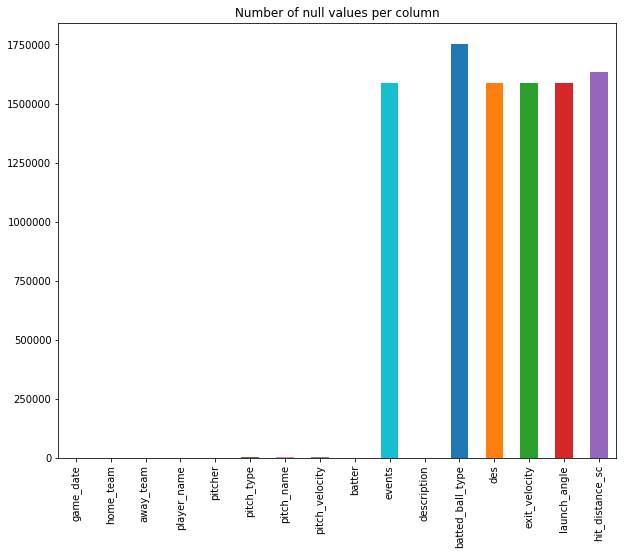

In [16]:
# Create a vertical bar plot by number of missing values per column using matplotlib
# Note: figsize: a tuple (width, height) in inches
all_MLB_teams2015_2017_new.isnull().sum().plot.bar(figsize=(10, 8));
plt.title('Number of null values per column');

#### Approach for excluding records:

Each record represents an interaction between a pitcher and a batter (i.e., a pitch thrown by the pitcher to the batter).  The goal is to keep any interaction for which Statcast could provide valid measurements for the metrics `launch_speed`, `launch_angle`, and `hit_distance_sc`.

In order to do so, non-batted ball records will be excluded. <br>

- Drop all `events` = NaN which represent interactions where the batter did not make contact with the ball or the batter made contact with the ball but it was hit foul (e.g., ball, foul, called strike, swinging strike, blocked ball, foul tip, intentional ball, foul bunt, swinging strike blocked, missed bunt, pitchout)

- Drop all `batted_ball_type` = NaN which represents other remaining events where there was not a batted ball (e.g., strikeout, walk, hit by pitch, intentional walk, caught stealing, etc.)

#### Examine `events` column for missingness.

In [17]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new.events.value_counts(dropna=False)

NaN                             1586052
field_out                        223381
strikeout                        116120
single                            82491
walk                              42138
double                            24898
home_run                          16629
force_out                         11500
grounded_into_double_play         11266
hit_by_pitch                       5019
field_error                        4816
sac_fly                            3549
sac_bunt                           3149
triple                             2607
intent_walk                        1884
double_play                        1348
fielders_choice_out                 919
caught_stealing_2b                  696
strikeout_double_play               435
fielders_choice                     301
pickoff_caught_stealing_2b          131
other_out                           120
catcher_interf                      113
pickoff_1b                           95
sac_fly_double_play                  66


In [18]:
# Detect missing values in a Series
# Note: True if missing, False if not missing
#cubs2016_new.events.isna() # alias of isnull()
null_events = all_MLB_teams2015_2017_new.events.isnull()
all_MLB_teams2015_2017_new[null_events]

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,pitch_velocity,batter,events,description,batted_ball_type,des,exit_velocity,launch_angle,hit_distance_sc
2139919,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,93.6,572761.0,NaN,called_strike,NaN,NaN,NaN,NaN,NaN
2139918,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,93.4,572761.0,NaN,swinging_strike,NaN,NaN,NaN,NaN,NaN
2139917,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,94.8,572761.0,NaN,foul,NaN,NaN,NaN,NaN,NaN
2139916,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,91.6,572761.0,NaN,ball,NaN,NaN,NaN,NaN,NaN
2139915,2015-04-05,CHC,STL,Jon Lester,452657.0,CU,Curveball,75.9,572761.0,NaN,ball,NaN,NaN,NaN,NaN,NaN
2139913,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,94.0,518792.0,NaN,ball,NaN,NaN,92.6,10.5026,186.0
2139911,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,92.7,407812.0,NaN,ball,NaN,NaN,NaN,NaN,NaN
2139910,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,89.9,407812.0,NaN,ball,NaN,NaN,NaN,NaN,NaN
2139908,2015-04-05,CHC,STL,Jon Lester,452657.0,SI,Sinker,91.1,425509.0,NaN,foul,NaN,NaN,NaN,NaN,NaN
2139907,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,91.2,425509.0,NaN,foul,NaN,NaN,101.5,6.2577,186.0


#### What types of interactions occurred for missing `events`?

In [19]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new[null_events].description.value_counts(dropna=False)

ball                       676751
foul                       371731
called_strike              333190
swinging_strike            131229
blocked_ball                45367
foul_tip                    10704
foul_bunt                    6228
intent_ball                  4724
swinging_strike_blocked      4312
missed_bunt                  1299
pitchout                      510
swinging_pitchout               4
foul_pitchout                   1
hit_into_play_score             1
hit_into_play                   1
Name: description, dtype: int64

#### Drop missing values from `events` column.

In [20]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['events'], inplace=True)

#### Examine `batted_ball_type` column for missingness.

In [21]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new.batted_ball_type.value_counts(dropna=False)

ground_ball    178646
NaN            166927
line_drive      99714
fly_ball        81752
popup           26829
Name: batted_ball_type, dtype: int64

In [22]:
# Detect missing values in a Series
# Note: True if missing, False if not missing
#all_MLB_teams2015_2017_new.batted_ball_type.isna() # alias of isnull()
null_batted_ball_type = all_MLB_teams2015_2017_new.batted_ball_type.isnull()
all_MLB_teams2015_2017_new[null_batted_ball_type]

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,pitch_velocity,batter,events,description,batted_ball_type,des,exit_velocity,launch_angle,hit_distance_sc
2139906,2015-04-05,CHC,STL,Jon Lester,452657.0,CU,Curveball,76.8,425509.0,strikeout,swinging_strike,NaN,Jhonny Peralta strikes out swinging.,NaN,NaN,NaN
2139901,2015-04-05,CHC,STL,Jon Lester,452657.0,FC,Cutter,89.9,571431.0,strikeout,swinging_strike,NaN,Matt Adams strikes out swinging.,NaN,NaN,NaN
2139890,2015-04-05,CHC,STL,Adam Wainwright,425794.0,FC,Cutter,84.9,519203.0,strikeout,called_strike,NaN,Anthony Rizzo called out on strikes.,NaN,NaN,NaN
2139882,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,92.0,425877.0,strikeout,swinging_strike,NaN,Yadier Molina strikes out swinging.,NaN,NaN,NaN
2139875,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,89.6,543939.0,walk,ball,NaN,Kolten Wong walks.,NaN,NaN,NaN
2139866,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,91.1,425794.0,strikeout,called_strike,NaN,Adam Wainwright called out on strikes.,NaN,NaN,NaN
2139864,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,88.7,518792.0,caught_stealing_2b,ball,NaN,"With Jason Heyward batting, Matt Carpenter cau...",NaN,NaN,NaN
2139854,2015-04-05,CHC,STL,Adam Wainwright,425794.0,CU,Curveball,77.1,592609.0,strikeout,swinging_strike_blocked,NaN,Mike Olt strikes out swinging.,NaN,NaN,NaN
2139849,2015-04-05,CHC,STL,Adam Wainwright,425794.0,FF,4-Seam Fastball,90.3,452657.0,strikeout,called_strike,NaN,Jon Lester called out on strikes.,NaN,NaN,NaN
2139837,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,92.7,425509.0,strikeout,called_strike,NaN,Jhonny Peralta called out on strikes.,NaN,NaN,NaN


#### What types of `events` occurred for missing `batted_ball_type`?

In [23]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new[null_batted_ball_type].events.value_counts(dropna=False)

strikeout                       116120
walk                             42138
hit_by_pitch                      5019
intent_walk                       1884
caught_stealing_2b                 696
strikeout_double_play              435
pickoff_caught_stealing_2b         131
other_out                          120
catcher_interf                     113
pickoff_1b                          95
caught_stealing_3b                  56
pickoff_2b                          55
caught_stealing_home                29
run                                 16
pickoff_caught_stealing_3b          10
batter_interference                  4
pickoff_caught_stealing_home         3
pickoff_3b                           3
Name: events, dtype: int64

#### Drop missing values from `batted_ball_type` column.

In [24]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['batted_ball_type'], inplace=True)

#### Confirm whether the values for `events` and `batted_ball_type` are valid (i.e., values could provide valid measurements for Statcast metrics).

In [25]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new.events.value_counts(dropna=False)

field_out                    223381
single                        82491
double                        24898
home_run                      16629
force_out                     11500
grounded_into_double_play     11266
field_error                    4816
sac_fly                        3549
sac_bunt                       3149
triple                         2607
double_play                    1348
fielders_choice_out             919
fielders_choice                 301
sac_fly_double_play              66
triple_play                      18
sac_bunt_double_play              3
Name: events, dtype: int64

In [26]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new.batted_ball_type.value_counts(dropna=False)

ground_ball    178646
line_drive      99714
fly_ball        81752
popup           26829
Name: batted_ball_type, dtype: int64

In [27]:
all_MLB_teams2015_2017_new.batted_ball_type.value_counts(dropna=False).sum()

386941

In [28]:
# Compute a frequency table of two factors
# Builtin-Styles - https://pandas.pydata.org/pandas-docs/stable/style.html
orange = sns.light_palette('orange', as_cmap=True)
pd.crosstab(all_MLB_teams2015_2017_new.events, all_MLB_teams2015_2017_new.batted_ball_type, margins=True, margins_name='Total', dropna=False).style.background_gradient(cmap=orange)

batted_ball_type,fly_ball,ground_ball,line_drive,popup,Total
events,,,,,
double,3502,3342,17914,140,24898
double_play,222,109,930,87,1348
field_error,159,4349,199,109,4816
field_out,60230,103445,33726,25980,223381
fielders_choice,0,301,0,0,301
fielders_choice_out,0,914,2,3,919
force_out,47,11342,74,37,11500
grounded_into_double_play,0,11266,0,0,11266
home_run,11547,0,5082,0,16629


Note: The above frequencies confirm valid values.

In [29]:
# Count the missing values in each column of a DataFrame - sum() works because True is 1 and False is 0
all_MLB_teams2015_2017_new.isnull().sum()

game_date               0
home_team               0
away_team               0
player_name             0
pitcher                 0
pitch_type            701
pitch_name            701
pitch_velocity        459
batter                  0
events                  0
description             0
batted_ball_type        0
des                     2
exit_velocity          66
launch_angle           66
hit_distance_sc     46472
dtype: int64

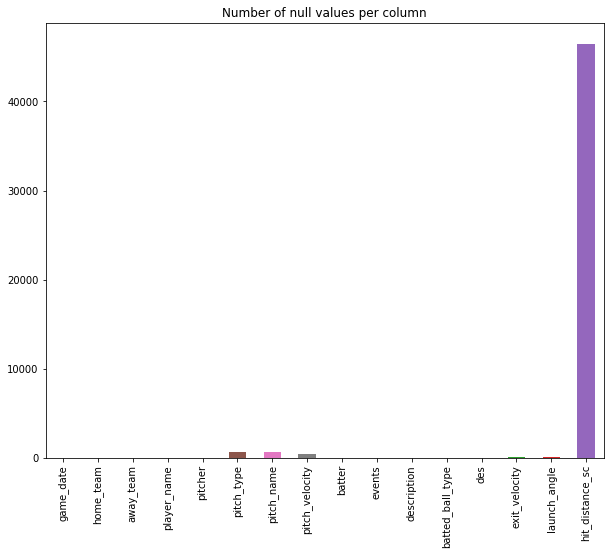

In [30]:
# Create a vertical bar plot by number of missing values per column using matplotlib
# Note: figsize: a tuple (width, height) in inches
all_MLB_teams2015_2017_new.isnull().sum().plot.bar(figsize=(10, 8));
plt.title('Number of null values per column');

Note: There are still missing values for the following variables: `pitch_name`, `pitch_velocity`, `exit_velocity`, `launch_angle`. These variables will be used in the modeling and observations with missing values will be dropped.

#### Drop missing values from `pitch_name`, `pitch_velocity`, `exit_velocity`, `launch_angle` columns.

In [31]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['pitch_name', 'pitch_velocity', 'exit_velocity', 'launch_angle'], inplace=True)

### Summarize the DataFrame

In [32]:
# Describe numeric columns
# Generates descriptive summary statistics of the central tendency, dispersion, and shape of the distribution
# Note: By default only numeric (int64) fields are returned
#       Excludes "NaN" (missing) values
# Remove multiple columns
# Note: axis=0 for rows, 1 for columns
all_MLB_teams2015_2017_new.drop(['pitcher', 'batter'], axis=1).describe()

,pitch_velocity,exit_velocity,launch_angle,hit_distance_sc
count,386112.000000,386112.000000,386112.000000,340221.000000
mean,88.938052,87.228387,10.662181,170.446680
std,5.809726,14.532315,27.245971,136.700367
min,41.500000,5.200000,-88.890000,0.000000
25%,85.100000,80.000000,-8.987000,22.000000
50%,90.300000,89.300000,10.605000,169.000000
75%,93.300000,98.100000,28.520775,294.000000
max,105.400000,123.400000,89.850000,504.000000


In [33]:
# Describe object columns (e.g. categorical, strings, or timestamps)
# Generates descriptive summary statistics of the count, unique values, top values, and frequency
# Note: "top" is the most common value; "freq" is the most common value's frequency
#       Excludes "NaN" (missing) values
# Remove multiple columns
# Note: axis=0 for rows, 1 for columns
all_MLB_teams2015_2017_new.drop(['home_team', 'away_team', 'player_name', 'des'], axis=1).describe(include='object')

,game_date,pitch_type,pitch_name,events,description,batted_ball_type
count,386112,386112,386112,386112,386112,386112
unique,537,16,16,16,4,4
top,2015-09-30,FF,4-Seam Fastball,field_out,hit_into_play,ground_ball
freq,974,131254,131254,222928,249245,178259


In [34]:
# Compute a frequency table of two factors
# Builtin-Styles - https://pandas.pydata.org/pandas-docs/stable/style.html
orange = sns.light_palette('orange', as_cmap=True)
pd.crosstab(all_MLB_teams2015_2017_new.pitch_name, all_MLB_teams2015_2017_new.pitch_type, margins=True, margins_name='Total').style.background_gradient(cmap=orange)

pitch_type,CH,CU,EP,FA,FC,FF,FO,FS,FT,KC,KN,PO,SC,SI,SL,UN,Total
pitch_name,,,,,,,,,,,,,,,,,
2-Seam Fastball,0,0,0,0,0,0,0,0,59444,0,0,0,0,0,0,0,59444
4-Seam Fastball,0,0,0,0,0,131254,0,0,0,0,0,0,0,0,0,0,131254
Changeup,43883,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43883
Curveball,0,26046,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26046
Cutter,0,0,0,0,21484,0,0,0,0,0,0,0,0,0,0,0,21484
Eephus,0,0,114,0,0,0,0,0,0,0,0,0,0,0,0,0,114
Fastball,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3
Forkball,0,0,0,0,0,0,126,0,0,0,0,0,0,0,0,0,126
Knuckle Ball,0,0,0,0,0,0,0,0,0,0,2094,0,0,0,0,0,2094


#### Drop low frequency `pitch_name` observations

In [35]:
# Return elements, either from `x` or `y`, depending on `condition`
all_MLB_teams2015_2017_new['pitch_name_low_freq'] = np.where(all_MLB_teams2015_2017_new.pitch_name.isin(['Eephus', 'Fastball', 'Forkball', 'Pitch Out', 'Screwball', 'Unknown']), 1, 0)

In [36]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new.pitch_name_low_freq.value_counts(dropna=False)

0    385848
1       264
Name: pitch_name_low_freq, dtype: int64

In [37]:
# Excluding low frequency values
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017_new[all_MLB_teams2015_2017_new.pitch_name_low_freq == 0]
all_MLB_teams2015_2017_new.drop('pitch_name_low_freq', axis=1, inplace=True)

In [38]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(all_MLB_teams2015_2017_new.shape[0], all_MLB_teams2015_2017_new.shape[1]))

Rows: 385848, Cols: 16


#### Create indicator for whether an event was a Home Run (HR).

In [39]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new.events.value_counts(dropna=False)

field_out                    222774
single                        82232
double                        24838
home_run                      16587
force_out                     11474
grounded_into_double_play     11234
field_error                    4806
sac_fly                        3539
sac_bunt                       3117
triple                         2599
double_play                    1345
fielders_choice_out             916
fielders_choice                 300
sac_fly_double_play              66
triple_play                      18
sac_bunt_double_play              3
Name: events, dtype: int64

In [40]:
# Lambda function: apply an arbitrary function to each value of a Pandas column, storing the result in a new column
all_MLB_teams2015_2017_new['hr'] = all_MLB_teams2015_2017_new.events.apply(lambda events: 1 if events == 'home_run' else 0)

In [41]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
print(all_MLB_teams2015_2017_new.hr.value_counts(dropna=False))
round(all_MLB_teams2015_2017_new.hr.value_counts(dropna=False) / len(all_MLB_teams2015_2017_new), 3)

0    369261
1     16587
Name: hr, dtype: int64


0    0.957
1    0.043
Name: hr, dtype: float64

#### Create indicator for whether an event was an Extra-base Hit (XBH).

In [42]:
# Check whether `values` are contained in Series
#all_MLB_teams2015_2017_new['xbh_bool'] = all_MLB_teams2015_2017_new.events.isin(['double', 'triple', 'home_run'])

In [43]:
# Map values of Series using input correspondence (i.e., map existing input values to new outputs values)
#all_MLB_teams2015_2017_new['xbh'] = all_MLB_teams2015_2017_new.xbh_bool.map({False:0, True:1})
#all_MLB_teams2015_2017_new.drop('xbh_bool', axis=1, inplace=True)

In [44]:
# Return elements, either from `x` or `y`, depending on `condition`
all_MLB_teams2015_2017_new['xbh'] = np.where(all_MLB_teams2015_2017_new.events.isin(['double', 'triple', 'home_run']), 1, 0)

In [45]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
print(all_MLB_teams2015_2017_new.xbh.value_counts(dropna=False))
round(all_MLB_teams2015_2017_new.xbh.value_counts(dropna=False) / len(all_MLB_teams2015_2017_new), 3)

0    341824
1     44024
Name: xbh, dtype: int64


0    0.886
1    0.114
Name: xbh, dtype: float64

In [46]:
# Calculate the correlation matrix using the default method (Pearson correlation)
baseball_correlations = all_MLB_teams2015_2017_new.drop(['pitcher', 'batter'], axis=1).corr(method='pearson')
baseball_correlations

,pitch_velocity,exit_velocity,launch_angle,hit_distance_sc,hr,xbh
pitch_velocity,1.000000,0.078758,0.006906,0.016692,-0.006979,-0.003404
exit_velocity,0.078758,1.000000,0.186630,0.352101,0.233394,0.302958
launch_angle,0.006906,0.186630,1.000000,0.732524,0.134847,0.134149
hit_distance_sc,0.016692,0.352101,0.732524,1.000000,0.375045,0.416674
hr,-0.006979,0.233394,0.134847,0.375045,1.000000,0.590573
xbh,-0.003404,0.302958,0.134149,0.416674,0.590573,1.000000


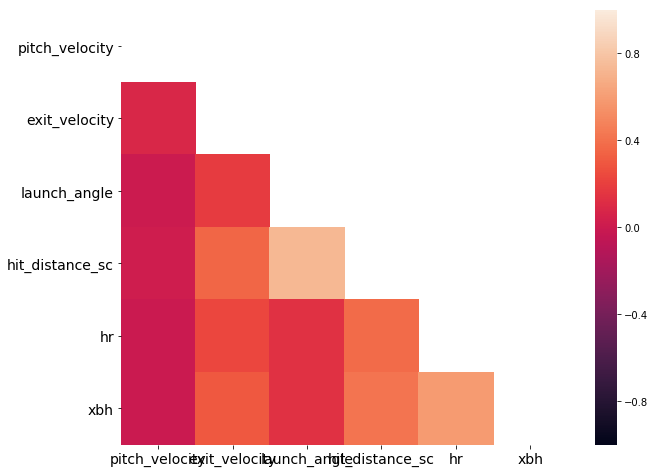

In [47]:
# Create a figure and a set of subplots
# Note: figsize: a tuple (width, height) in inches
fig, ax = plt.subplots(figsize=(10, 8));

# Return an array of zeros with the same shape and type as a given array
mask = np.zeros_like(baseball_correlations, dtype=np.bool)
# Return the indices for the upper-triangle of array
mask[np.triu_indices_from(mask)] = True

# Plot the correlation matrix (color-encoded) using Seaborn's .heatmap() function
# Note: vmin, vmax: values to anchor the colormap, otherwise they are inferred from the data & other keyword arguments
ax = sns.heatmap(baseball_correlations, vmin=-1, vmax=1, mask=mask, ax=ax);

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14);
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14);

plt.show();

In [48]:
# For each HR group, describe exit velocity:
all_MLB_teams2015_2017_new.groupby(by='hr').exit_velocity.describe()

,count,mean,std,min,25%,50%,75%,max
hr,,,,,,,,
0,369261.0,86.511807,14.414668,5.2,80.0,88.6,97.1,123.4
1,16587.0,103.234033,4.414319,36.6,100.5,103.3,106.2,121.1


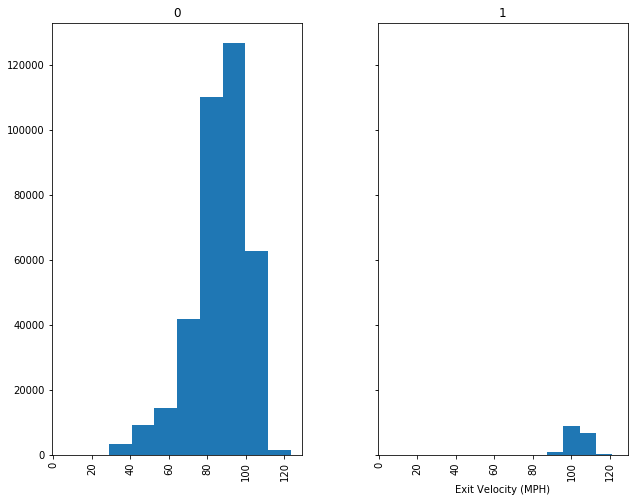

In [49]:
# Create histograms
# Note: column: used to limit data to a subset of columns
#       by: used to form histograms for separate groups
#       sharex: share x axis and set some x axis labels to invisible
#       sharey: share y axis and set some y axis labels to invisible
#       layout: tuple of (rows, columns) for the layout of the histograms
#       figsize: a tuple (width, height) in inches
all_MLB_teams2015_2017_new.hist(column='exit_velocity', by='hr', sharex=True, sharey=True, figsize=(10, 8));
plt.xlabel('Exit Velocity (MPH)');
plt.ylabel('Frequency');

In [50]:
# For each HR group, describe launch angle:
all_MLB_teams2015_2017_new.groupby(by='hr').launch_angle.describe()

,count,mean,std,min,25%,50%,75%,max
hr,,,,,,,,
0,369261.0,9.883912,27.574537,-88.890,-10.133,9.102,27.6080,89.850
1,16587.0,27.997869,5.258122,-47.842,24.156,27.650,31.3585,49.741


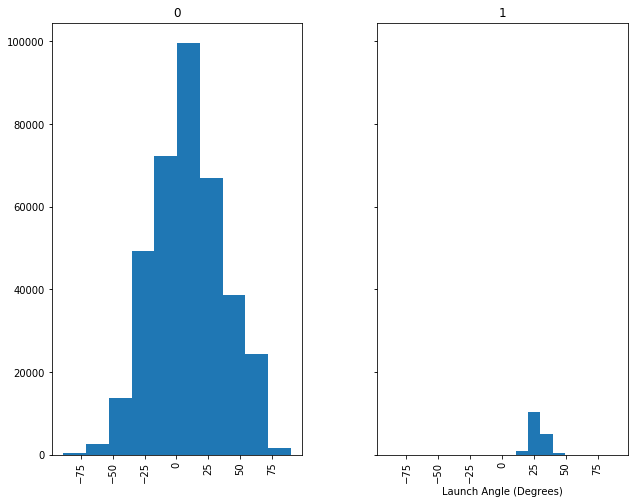

In [51]:
# Create histograms
# Note: column: used to limit data to a subset of columns
#       by: used to form histograms for separate groups
#       sharex: share x axis and set some x axis labels to invisible
#       sharey: share y axis and set some y axis labels to invisible
#       layout: tuple of (rows, columns) for the layout of the histograms
#       figsize: a tuple (width, height) in inches
all_MLB_teams2015_2017_new.hist(column='launch_angle', by='hr', sharex=True, sharey=True, figsize=(10, 8));
plt.xlabel('Launch Angle (Degrees)');
plt.ylabel('Frequency');

In [52]:
# For each XBH group, describe exit velocity:
all_MLB_teams2015_2017_new.groupby(by='xbh').exit_velocity.describe()

,count,mean,std,min,25%,50%,75%,max
xbh,,,,,,,,
0,341824.0,85.650642,14.394967,5.2,79.5,87.4,96.0,123.4
1,44024.0,99.498778,8.496135,32.2,96.5,101.2,104.8,121.1


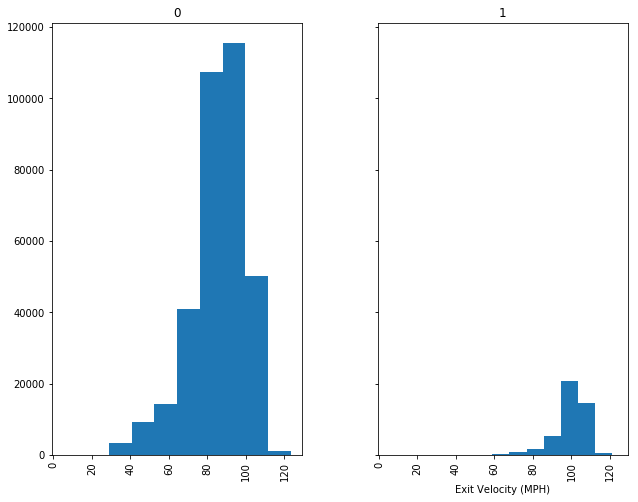

In [53]:
# Create histograms
# Note: column: used to limit data to a subset of columns
#       by: used to form histograms for separate groups
#       sharex: share x axis and set some x axis labels to invisible
#       sharey: share y axis and set some y axis labels to invisible
#       layout: tuple of (rows, columns) for the layout of the histograms
#       figsize: a tuple (width, height) in inches
all_MLB_teams2015_2017_new.hist(column='exit_velocity', by='xbh', sharex=True, sharey=True, figsize=(10, 8));
plt.xlabel('Exit Velocity (MPH)');
plt.ylabel('Frequency');

In [54]:
# For each XBH group, describe launch angle:
all_MLB_teams2015_2017_new.groupby(by='xbh').launch_angle.describe()

,count,mean,std,min,25%,50%,75%,max
xbh,,,,,,,,
0,341824.0,9.350901,28.432802,-88.890,-11.9267,7.282,28.96625,89.85
1,44024.0,20.847295,10.596456,-62.942,15.5800,21.752,27.62325,69.72


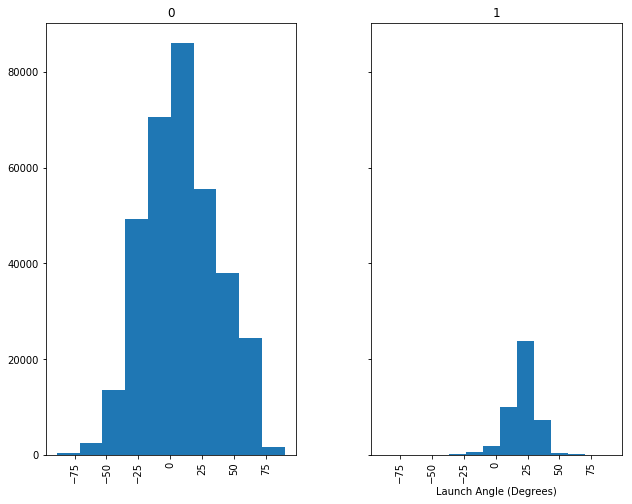

In [55]:
# Create histograms
# Note: column: used to limit data to a subset of columns
#       by: used to form histograms for separate groups
#       sharex: share x axis and set some x axis labels to invisible
#       sharey: share y axis and set some y axis labels to invisible
#       layout: tuple of (rows, columns) for the layout of the histograms
#       figsize: a tuple (width, height) in inches
all_MLB_teams2015_2017_new.hist(column='launch_angle', by='xbh', sharex=True, sharey=True, figsize=(10, 8));
plt.xlabel('Launch Angle (Degrees)');
plt.ylabel('Frequency');

### Data Modeling

### Using Logistic Regression for Classification

Logistic regression: Log odds of a categorical response being "true" (1) is modeled as a linear combination of the features.

$$\log \left({p\over 1-p}\right) = \beta_0 + \beta_1x$$

This is called the logit function.

The equation can be rearranged into the logistic function.

$$\hat{p} = \frac{e^{\beta_0 + \beta_1x}} {1 + e^{\beta_0 + \beta_1x}}$$

#### Build and train logistic regression models

Create dummy variables for `pitch_name`.

In [56]:
# Convert categorical variable into dummy/indicator variables
# Note: prefix: string to append DataFrame column names
#       drop_first=True removes the first level to get k-1 dummies out of k categorical events
# Join columns with other DataFrame either on index or on a key
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017_new.join(pd.get_dummies(all_MLB_teams2015_2017_new.pitch_name, prefix='pitch_name', drop_first=True))
all_MLB_teams2015_2017_new.head()

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,pitch_velocity,batter,events,...,xbh,pitch_name_4-Seam Fastball,pitch_name_Changeup,pitch_name_Curveball,pitch_name_Cutter,pitch_name_Knuckle Ball,pitch_name_Knuckle Curve,pitch_name_Sinker,pitch_name_Slider,pitch_name_Split Finger
2139914,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,93.6,572761.0,field_out,...,0,1,0,0,0,0,0,0,0,0
2139912,2015-04-05,CHC,STL,Jon Lester,452657.0,FC,Cutter,89.9,518792.0,double,...,1,0,0,0,1,0,0,0,0,0
2139909,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,93.2,407812.0,single,...,0,1,0,0,0,0,0,0,0,0
2139899,2015-04-05,CHC,STL,Adam Wainwright,425794.0,FC,Cutter,88.1,451594.0,double,...,1,0,0,0,1,0,0,0,0,0
2139895,2015-04-05,CHC,STL,Adam Wainwright,425794.0,FC,Cutter,89.9,624585.0,field_out,...,0,0,0,0,1,0,0,0,0,0


### Building Phase

#### Predicting HRs

In [57]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
print(all_MLB_teams2015_2017_new.hr.value_counts(dropna=False))
print()
print('Percentage of HR=No(0), HR=Yes(1)')
round(all_MLB_teams2015_2017_new.hr.value_counts(dropna=False)/len(all_MLB_teams2015_2017_new), 3)

0    369261
1     16587
Name: hr, dtype: int64

Percentage of HR=No(0), HR=Yes(1)


0    0.957
1    0.043
Name: hr, dtype: float64

Note: CLASSES ARE HIGHLY IMBALANCED!!

#### Over-sampling using Synthetic Minority Over-Sampling Technique (SMOTE)
- Works by creating synthetic samples from the minor class (HR=Yes) instead of creating copies.
- Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [58]:
# Create a list of features
feature_cols = ['pitch_name_4-Seam Fastball', 'pitch_name_Changeup', 'pitch_name_Curveball', 'pitch_name_Cutter',
                'pitch_name_Knuckle Ball', 'pitch_name_Knuckle Curve', 'pitch_name_Sinker', 'pitch_name_Slider', 'pitch_name_Split Finger',
                'pitch_velocity', 'exit_velocity', 'launch_angle']

In [59]:
# Create X and y
X = all_MLB_teams2015_2017_new[feature_cols]
y = all_MLB_teams2015_2017_new.hr

In [60]:
# Split X and y into training and testing sets
# Note: train_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split
#       test_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
#       random_state: the seed used by the random number generator
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, test_size=0.30, random_state=65)

#### Compute Baseline Accuracy
https://machinelearningmastery.com/how-to-get-baseline-results-and-why-they-matter/

In [61]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
print(y_train.value_counts())
print()

most_freq_class = y_train.value_counts().index[0]
print('Most frequent class in training dataset:', most_freq_class)
print()

print('Baseline accuracy:', round(y_test.value_counts()[most_freq_class] / y_test.count(), 3))

0    258469
1     11624
Name: hr, dtype: int64

Most frequent class in training dataset: 0

Baseline accuracy: 0.957


In [62]:
print('Length of X_train: {}'.format(len(X_train)))
print('Length of y_train: {}'.format(len(y_train)))
print('Length of X_test: {}'.format(len(X_test)))
print('Length of y_test: {}'.format(len(y_test)))

Length of X_train: 270093
Length of y_train: 270093
Length of X_test: 115755
Length of y_test: 115755


In [63]:
print('Before over-sampling, counts of label "0": {}'.format(sum(y_train==0)))
print('Before over-sampling, counts of label "1": {}'.format(sum(y_train==1)))

Before over-sampling, counts of label "0": 258469
Before over-sampling, counts of label "1": 11624


In [64]:
# Class to perform over-sampling using SMOTE
# -> Implementation of SMOTE and the variants Borderline SMOTE 1, 2 and SVM-SMOTE
# Note: random_state: the seed used by the random number generator
#       kind: type of SMOTE algorithm to use: 'regular', 'borderline1', 'borderline2', 'svm'
sm = SMOTE(random_state=42, kind='regular')

Note: Over-sampling only on the training data. By over-sampling on the training data only, none of the information in the test data is being used to create synthetic observations. Therefore, no information will bleed from test data into the model training.

In [65]:
# Fit the statistics and resample the data directly
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [66]:
print('After over-sampling, the length of X_train_res: {}'.format(len(X_train_res)))
print('After over-sampling, the length of y_train_res: {} \n'.format(len(y_train_res)))

print('After over-sampling, counts of label "0": {}'.format(sum(y_train_res==0)))
print('After over-sampling, counts of label "1": {}'.format(sum(y_train_res==1)))

After over-sampling, the length of X_train_res: 516938
After over-sampling, the length of y_train_res: 516938 

After over-sampling, counts of label "0": 258469
After over-sampling, counts of label "1": 258469


In [67]:
print('Proportion of label "0" in over-sampled data', sum(y_train_res==0)/len(X_train_res))
print('Proportion of label "1" in over-sampled data', sum(y_train_res==1)/len(X_train_res))

Proportion of label "0" in over-sampled data 0.5
Proportion of label "1" in over-sampled data 0.5


Note: CLASSES ARE PERFECTLY BALANCED!!

In [68]:
# Instantiate a Logistic Regression classifier and fit logistic model
# Note: random_state: the seed used by the random number generator
logreg = LogisticRegression(random_state=46)
logreg.fit(X_train_res, y_train_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=46, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [69]:
# Predict the class labels using the logistic model
y_pred_class = logreg.predict(X_test)

In [70]:
# Calculate predicted probability estimates of class membership
# Each row sums to one and contains the probabilities of the point being a 0-Window glass, 1-Household glass
logreg.predict_proba(X_test)[0:10]

array([[9.99880799e-01, 1.19200968e-04],
       [9.99999892e-01, 1.08045585e-07],
       [9.98515800e-01, 1.48420043e-03],
       [7.00834237e-01, 2.99165763e-01],
       [9.99996433e-01, 3.56667008e-06],
       [9.99993552e-01, 6.44805894e-06],
       [9.98816373e-01, 1.18362729e-03],
       [9.99999847e-01, 1.52542818e-07],
       [2.10264788e-01, 7.89735212e-01],
       [9.95715166e-01, 4.28483390e-03]])

In [71]:
# Calculate predicted probability estimates
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

#### Get the coefficient for each feature

In [72]:
name = X.columns
coef = np.round(logreg.coef_[0], 4)
pd.DataFrame([name, coef], index=['Name', 'Coefficient']).transpose()

,Name,Coefficient
0,pitch_name_4-Seam Fastball,0.1557
1,pitch_name_Changeup,-0.0139
2,pitch_name_Curveball,-0.238
3,pitch_name_Cutter,-0.1103
4,pitch_name_Knuckle Ball,-0.9075
5,pitch_name_Knuckle Curve,-0.6822
6,pitch_name_Sinker,-0.2966
7,pitch_name_Slider,0.0973
8,pitch_name_Split Finger,-0.0915
9,pitch_velocity,-0.0633


### Operational Phase

In [73]:
# Function to make predictions 
def prediction(X_test, logreg_object): 
  
    # Predict the class labels using the logistic model
    y_pred_class = logreg_object.predict(X_test)

    print('Predicted values:')
    print(y_pred_class)
    print('')
    return y_pred_class

In [74]:
# Function to calculate accuracy
def cal_accuracy(y_test, y_pred_class, logreg_object):
      
    # Training accuracy classification score
    print('Training accuracy score:', round(metrics.accuracy_score(y_train_res, logreg_object.predict(X_train_res)), 3))
    
    # Testing accuracy classification score
    print('Testing accuracy score:', round(metrics.accuracy_score(y_test, y_pred_class), 3))
    
    if metrics.accuracy_score(y_train_res, logreg_object.predict(X_train_res)) < metrics.accuracy_score(y_test, y_pred_class):
        print('Testing accuracy > Training accuracy')
        print('-> Not overfitting')
    else:
        print('Testing accuracy < Training accuracy')
        print('-> Overfitting!')
    print('')
    
    # Confusion matrix to evaluate the accuracy of a classification
    print('Confusion Matrix:')
    conmat = metrics.confusion_matrix(y_test, y_pred_class)
    print(pd.DataFrame(conmat,
                       index=['True No HR', 'True HR'],
                       columns=['Predicted No HR', 'Predicted HR']))
    print('')
    
    # Build a text report showing the main classification metrics
    print('Classification Report:')
    print(metrics.classification_report(y_test, y_pred_class))
    print('')
    
    # Area Under the Receiver Operating Characteristic Curve (ROC AUC)
    print('ROC AUC:', round(metrics.roc_auc_score(y_test, y_pred_class), 3))
    print('')
    
    # Log loss, aka logistic loss or cross-entropy loss
    print('Log loss:', round(metrics.log_loss(y_test, y_pred_class), 3))

[Classification Accuracy is Not Enough: More Performance Measures You Can Use](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/)

$$Precision = Positive Predictive Value (PPV) = \frac{True Positives}{True Positives + False Positives}--> completeness$$
- "How many of the items selected are relevant"
- Of the items placed into a class, how many of them are True Positives.
- The ability of the classifier to not label a sample as positive if it is negative.
<br>
<br>
$$Recall = True Positive Rate(Sensitivity) = \frac{True Positives}{True Positives + False Negatives}-->exactness$$
- "How many of the relevant items are selected"
- Of the items that were suppose to be placed into a class, how many did we accurately place.
- The ability of the classifier to find all the positive samples.
<br>
<br>
$$F1Score = 2*\frac{precision * recall}{precision + recall}$$
- 0 <= F1 <= 1, where 0 is awful and 1 is perfection.
- F1 is considered a harmonic mean as it averages Precision and Recall.
- With classification models you often times have to choose what kind of error you are willing to increase in order to reduce the other and thus you may want to optimize Precision or Recall accordingly.
- If you are uncertain which you should optimize, F1 score may be the metric of choice.

#### Prediction using logistic regression

In [75]:
print('Results Using Logistic Regression:')
y_pred_logreg = prediction(X_test, logreg)
cal_accuracy(y_test, y_pred_logreg, logreg)

Results Using Logistic Regression:
Predicted values:
[0 0 0 ... 0 0 0]

Training accuracy score: 0.897
Testing accuracy score: 0.868
Testing accuracy < Training accuracy
-> Overfitting!

Confusion Matrix:
            Predicted No HR  Predicted HR
True No HR            95828         14964
True HR                 354          4609

Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.86      0.93    110792
          1       0.24      0.93      0.38      4963

avg / total       0.96      0.87      0.90    115755


ROC AUC: 0.897

Log loss: 4.571


#### Use Regularization to optimize model

In [76]:
parameters = {'penalty': ('l1', 'l2'), 'C': [0.01, 0.1, 1.0, 10, 100]}

In [77]:
# Instantiate a Logistic Regression classifier
# Note: penalty: used to specify the norm used in the penalization; l1 penalty with SAGA solver (allowing 'multinomial' + L1)
#       C: inverse of regularization strength (default: 1.0); must be a positive float; like in support vector machines, smaller values specify stronger regularization
#       random_state: the seed used by the random number generator
logreg = LogisticRegression(random_state=46)

In [78]:
# Instantiate an exhaustive search over specified parameter values for an estimator and run fit with all sets of parameters
# Note: estimator: estimator object
#       param_grid: dictionary with parameters names (string) as keys and lists of parameter settings to try as values; 
#                   this enables searching over any sequence of parameter settings
#       cv: number of folds in k-fold cross-validation
#       return_train_score: if False, the cv_results_ attribute will not include training scores
clf = GridSearchCV(estimator=logreg, param_grid=parameters, cv=10, return_train_score=True)
clf.fit(X_train_res, y_train_res)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=46, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2'), 'C': [0.01, 0.1, 1.0, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [79]:
results = pd.DataFrame.from_dict(clf.cv_results_)
pd.DataFrame.from_dict(clf.cv_results_, orient='index')

,0,1,2,3,4,5,6,7,8,9
mean_fit_time,20.2615,1.34342,29.1352,1.78498,30.4217,1.86196,30.8871,2.2082,33.5571,2.23588
std_fit_time,3.44204,0.123182,5.26299,0.110183,2.49465,0.120145,1.76112,0.422595,2.20215,0.281724
mean_score_time,0.00739863,0.00592647,0.00817454,0.00537744,0.00868289,0.00531571,0.00804267,0.00595858,0.00789289,0.00658371
std_score_time,0.000261883,0.00106633,0.00176956,0.000326435,0.00349207,0.000436392,0.00157159,0.00164804,0.000612637,0.00129249
param_C,0.01,0.01,0.1,0.1,1,1,10,10,100,100
param_penalty,l1,l2,l1,l2,l1,l2,l1,l2,l1,l2
params,"{'C': 0.01, 'penalty': 'l1'}","{'C': 0.01, 'penalty': 'l2'}","{'C': 0.1, 'penalty': 'l1'}","{'C': 0.1, 'penalty': 'l2'}","{'C': 1.0, 'penalty': 'l1'}","{'C': 1.0, 'penalty': 'l2'}","{'C': 10, 'penalty': 'l1'}","{'C': 10, 'penalty': 'l2'}","{'C': 100, 'penalty': 'l1'}","{'C': 100, 'penalty': 'l2'}"
split0_test_score,0.895056,0.884571,0.895152,0.894649,0.895152,0.895636,0.895152,0.895249,0.895152,0.895423
split1_test_score,0.895617,0.886196,0.895752,0.895307,0.895655,0.896352,0.895636,0.896042,0.895636,0.896023
split2_test_score,0.896545,0.886525,0.896951,0.8961,0.896932,0.897396,0.896951,0.897261,0.896951,0.89728


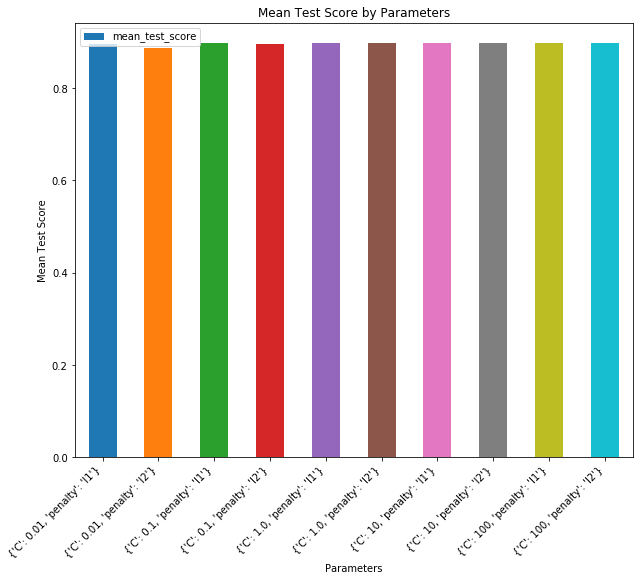

In [80]:
# Create a vertical bar plot by mean test score using matplotlib
# Note: figsize: a tuple (width, height) in inches
ax = results.plot.bar(y='mean_test_score', x='params', figsize=(10, 8));
ax.set_xticklabels(results.params, rotation=45, horizontalalignment='right');
plt.xlabel('Parameters');
plt.ylabel('Mean Test Score');
plt.title('Mean Test Score by Parameters');

In [81]:
print('Best parameter setting found by grid search:')
print(clf.best_params_)
print()
print('Best mean cross-validated score found by grid search:')
print(round(clf.best_score_, 3))

Best parameter setting found by grid search:
{'C': 1.0, 'penalty': 'l2'}

Best mean cross-validated score found by grid search:
0.897


#### Prediction using logistic regression, regularization, and cross-validation

In [82]:
print('Results Using Logistic Regression, Regularization, and Cross-Validation:')
y_pred_clf = prediction(X_test, clf)
cal_accuracy(y_test, y_pred_clf, clf)

Results Using Logistic Regression, Regularization, and Cross-Validation:
Predicted values:
[0 0 0 ... 0 0 0]

Training accuracy score: 0.897
Testing accuracy score: 0.868
Testing accuracy < Training accuracy
-> Overfitting!

Confusion Matrix:
            Predicted No HR  Predicted HR
True No HR            95828         14964
True HR                 354          4609

Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.86      0.93    110792
          1       0.24      0.93      0.38      4963

avg / total       0.96      0.87      0.90    115755


ROC AUC: 0.897

Log loss: 4.571


#### Plot Receiver Operating Characteristic (ROC) Curve

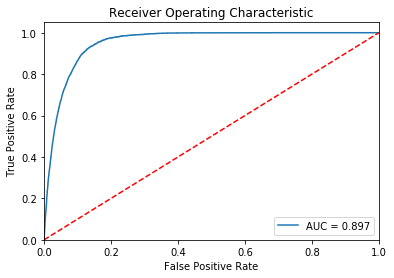

In [83]:
roc_auc = metrics.roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:, 1])

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.3f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()